# Benchmark modelling

This notebook will calculate benchmarks for the model, namely (1) Simple heuristics and (2) Simple machine learning models and classical statistical models.




First, we set the file paths and import important libraries:

In [1]:
%reset -f

In [2]:
import os
ROOT_PATH = os.path.abspath(".").split("main")[0]
MAIN_PATH = ROOT_PATH + "main/"
EXPORT_PATH = ROOT_PATH + "exports/"
DATA_PATH = ROOT_PATH + "data/"
SAVE_PATH = ROOT_PATH + "save/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from cognite.v05.assets import get_assets
from cognite.v05.assets import get_asset
from cognite.v05.timeseries import get_datapoints_frame

In [6]:
# Use the seaborn theme as this looks better than the standard matplotlib
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

In [5]:
# Authenticate session with Cognite API
from cognite.config import configure_session
from credentials import COGNITE_API_KEY
configure_session(COGNITE_API_KEY, 'publicdata')

In [34]:
# read the data
df = pd.read_pickle(DATA_PATH + "unprocessed_data.pkl")

df2np = np.load(DATA_PATH + "standardized_complete.npy")
df2np_train = np.load(DATA_PATH + "standardized_train.npy")
df2np_valid = np.load(DATA_PATH + "standardized_valid.npy")
df2np_test = np.load(DATA_PATH + "standardized_test.npy")

print(df2np.shape)
print(df2np_train.shape)
print(df2np_valid.shape)
print(df2np_test.shape)
print(df2np_train.shape[0] + df2np_valid.shape[0] + df2np_test.shape[0])

# read metadata
feature_tags = list(np.load(DATA_PATH + "feature_tags.npy"))
target_tags = list(np.load(DATA_PATH + "target_tags.npy"))
headers = feature_tags + target_tags

means = np.load(DATA_PATH + "means.npy")
stds = np.load(DATA_PATH + "stds.npy")

(5757, 9)
(3454, 9)
(1151, 9)
(1152, 9)
5757


# Implementation of simple heuristics

In [137]:
# unstandardize the data
df2np_unstd = np.copy(df2np)
df2np_unstd *= stds
df2np_unstd += means

train_size = df2np_train.shape[0]
valid_size = df2np_valid.shape[0]
test_size = df2np_test.shape[0]

# true targets from validation set
temp_out = 'VAL_23-TT-92539:X.Value|average'
temp_ind = headers.index(temp_out)
flow_out = 'VAL_23-FT-92537-01:X.Value|average'
flow_ind = headers.index(flow_out)
pres_out = 'VAL_23-PT-92539:X.Value|average'
pres_ind = headers.index(pres_out)

## Baselines on validation data

In [59]:
targets_temp = df2np_unstd[train_size:-test_size, temp_ind]
targets_flow = df2np_unstd[train_size:-test_size, flow_ind]
targets_pres = df2np_unstd[train_size:-test_size, pres_ind]

targets_arr = [("Temperature [C]", temp_ind, targets_temp),
               ("Flow [kg/h]", flow_ind, targets_flow),
               ("Pressure [barg]", pres_ind, targets_pres)]

In [132]:
# define RMSE and MAE loss functions
def RMSE(targets, predictions):
    return round(np.sqrt(np.mean(np.square(targets - predictions))), 5)

def MAE(targets, predictions):
    return round(np.mean(np.abs(targets - preds)), 5)

### Predict the the previous value
Now setting $y(t+1) = y(t)$

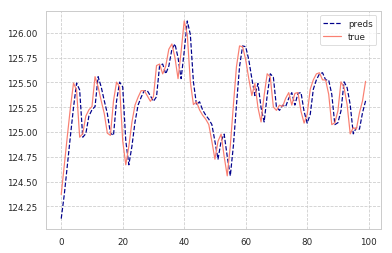

In [173]:
# visualise with a plot
preds = targets_temp[:-1]
targets = targets_temp[1:]
plt.figure()
plt.plot(preds[:100], label="preds", linestyle="dashed", color="darkblue")
plt.plot(targets[:100], label="true", color="salmon")
plt.legend(frameon=True)
plt.show()

In [134]:
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    preds = param[2][:-1]
    targets = param[2][1:]
    print(param[0])
    print("MAE: {0}".format(MAE(targets,preds)))
    print("RMSE: {0}".format(RMSE(targets,preds)))
    print()

Temperature [C]
MAE: 0.18958
RMSE: 0.2417

Flow [kg/h]
MAE: 2439.26484
RMSE: 3069.60077

Pressure [barg]
MAE: 0.16343
RMSE: 0.21156



### Predict the mean value
Now setting $y(t) = \sum_{i=0}^{T}y(i)$ where T is the time of the last observation in the training data

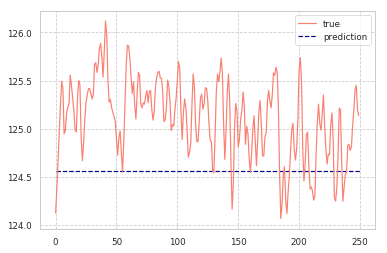

In [171]:
# visualise with a plot with the 100 first data points
preds = means[temp_ind]
targets = targets_temp
plt.figure()
plt.plot(targets[:250], color="salmon", label="true")
plt.hlines(y=preds, xmin=0, xmax=250, linestyle="dashed", color="darkblue", label="prediction")
plt.legend(frameon=True)
plt.show()

In [136]:
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    preds = means[param[1]]
    targets = param[2]
    print(param[0])
    print("MAE: {0}".format(MAE(targets,preds)))
    print("RMSE: {0}".format(RMSE(targets,preds)))
    print()

Temperature [C]
MAE: 0.69346
RMSE: 0.79371

Flow [kg/h]
MAE: 1999.43484
RMSE: 2568.54006

Pressure [barg]
MAE: 0.16774
RMSE: 0.20355



### Predict with a moving average

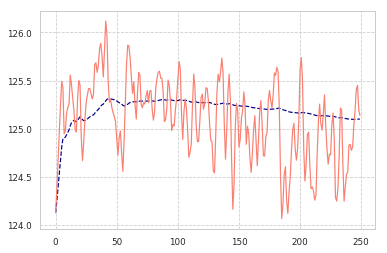

In [169]:
cumsum = np.cumsum(targets_temp)
ma = [cumsum[n-1]/n for n in range(1,len(cumsum)+1)]
targets = targets_temp

plt.figure()
plt.plot(ma[:250], linestyle="dashed", color="darkblue", label="moving average")
plt.plot(targets[:250], color="salmon", label="true")
plt.show()

In [161]:
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    cumsum = np.cumsum(param[2])
    preds = [cumsum[n-1]/n for n in range(1,len(cumsum)+1)]
    targets = param[2]
    
    print(param[0])
    print("MAE: {0}".format(MAE(targets,preds)))
    print("RMSE: {0}".format(RMSE(targets,preds)))
    print()

Temperature [C]
MAE: 0.36479
RMSE: 0.47413

Flow [kg/h]
MAE: 1974.04555
RMSE: 2470.78158

Pressure [barg]
MAE: 0.17058
RMSE: 0.21048



## Baselines on the test set

In [139]:
targets_temp = df2np_unstd[-test_size:, temp_ind]
targets_flow = df2np_unstd[-test_size:, flow_ind]
targets_pres = df2np_unstd[-test_size:, pres_ind]

targets_arr = [("Temperature [C]", temp_ind, targets_temp),
               ("Flow [kg/h]", flow_ind, targets_flow),
               ("Pressure [barg]", pres_ind, targets_pres)]

### Predicting the previous value

In [140]:
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    preds = param[2][:-1]
    targets = param[2][1:]
    print(param[0])
    print("MAE: {0}".format(MAE(targets,preds)))
    print("RMSE: {0}".format(RMSE(targets,preds)))
    print()

Temperature [C]
MAE: 0.19092
RMSE: 0.24486

Flow [kg/h]
MAE: 2592.57747
RMSE: 3273.2823

Pressure [barg]
MAE: 0.16519
RMSE: 0.21155



### Predicting the mean value

In [141]:
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    preds = means[param[1]]
    targets = param[2]
    print(param[0])
    print("MAE: {0}".format(MAE(targets,preds)))
    print("RMSE: {0}".format(RMSE(targets,preds)))
    print()

Temperature [C]
MAE: 0.4203
RMSE: 0.52058

Flow [kg/h]
MAE: 2056.54625
RMSE: 2612.44543

Pressure [barg]
MAE: 0.17191
RMSE: 0.21113



### Predict the moving average

In [174]:
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    cumsum = np.cumsum(param[2])
    preds = [cumsum[n-1]/n for n in range(1,len(cumsum)+1)]
    targets = param[2]
    
    print(param[0])
    print("MAE: {0}".format(MAE(targets,preds)))
    print("RMSE: {0}".format(RMSE(targets,preds)))
    print()

Temperature [C]
MAE: 0.36479
RMSE: 0.47413

Flow [kg/h]
MAE: 1974.04555
RMSE: 2470.78158

Pressure [barg]
MAE: 0.17058
RMSE: 0.21048



# Simple Machine learning models

### Random forest with lagged variables

In [175]:
# import relevant libraries
from sklearn.ensemble import RandomForestRegressor

In [286]:
feature_idxs = range(len(feature_tags))
target_idxs = range(len(feature_tags),len(headers))

train = np.copy(df2np_train)
valid = np.copy(df2np_valid)

# unstandardize the data
train *= stds
train += means
valid *= stds
valid += means

lag = 1
x_train = train[:-lag,feature_idxs]
y_train = train[lag:,target_idxs]
x_valid = valid[:-lag,feature_idxs]
y_valid = valid[lag:,target_idxs]
    

Find the optimal number of parameters by iteratively increasing the number of trees

In [287]:
rf = RandomForestRegressor(oob_score=True,
                           random_state=0,
                           max_features='sqrt',
                           n_jobs=-1)

def get_oob_per_tree(rf_model, x_train, y_train, ntrees_min=50, ntrees_max=2000, delta=50):
    
    trees_arr = np.arange(ntrees_min,ntrees_max+delta,delta)
    oob_errors = np.zeros(len(trees_arr))
    
    for i, ntrees in enumerate(trees_arr):
        rf_model.set_params(n_estimators=ntrees)
        rf_model.fit(x_train, y_train)
        
        print("ntrees={0}, oob_error={1}".format(ntrees,round(1 - rf_model.oob_score_,5)))
        oob_errors[i] = 1 - rf_model.oob_score_
    return oob_errors

ntrees_min = 20
ntrees_max = 500
delta = 50
oob_errors = get_oob_per_tree(rf, x_train, y_train[:,0], ntrees_min, ntrees_max, delta)

ntrees=20, oob_error=0.81983
ntrees=70, oob_error=0.73417
ntrees=120, oob_error=0.72679
ntrees=170, oob_error=0.72354
ntrees=220, oob_error=0.72118
ntrees=270, oob_error=0.71764
ntrees=320, oob_error=0.71629
ntrees=370, oob_error=0.71575
ntrees=420, oob_error=0.71588
ntrees=470, oob_error=0.7141
ntrees=520, oob_error=0.71292


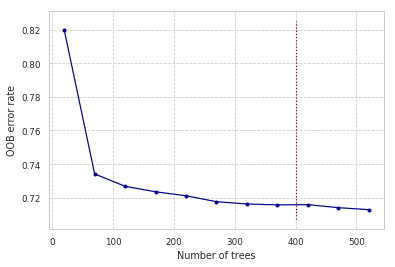

In [288]:
plt.figure()
plt.plot(np.arange(ntrees_min,ntrees_max+delta,delta), oob_errors, marker='o', markersize=3.0, color="darkblue")
plt.vlines(x=400,ymin=plt.ylim()[0],ymax=plt.ylim()[1], linestyle="dotted", color="darkred")
plt.xlabel('Number of trees')
plt.ylabel('OOB error rate')
plt.show()

From the plot, we choose to use set `ntrees`=400, as it seems like the model has converged by then.

In [292]:
ntrees=400
rf.set_params(n_estimators=ntrees)

temp_ind = target_tags.index(temp_out)
flow_ind = target_tags.index(flow_out)
pres_ind = target_tags.index(pres_out)

targets_arr = [("Temperature [C]", temp_ind),
               ("Flow [kg/h]", flow_ind),
               ("Pressure [barg]", pres_ind)]

print("==== Random Forest ====")
for i in range(len(targets_arr)):
    param = targets_arr[i]
    
    rf.fit(x_train, y_train[:,param[1]])
    preds = rf.predict(x_valid)
    print(param[0])
    print("OOB:", 1 - rf.oob_score_)
    print("MAE:", MAE(y_valid[:,param[1]], preds))
    print("RMSE:", RMSE(y_valid[:,param[1]], preds))
    print()

==== Random Forest ====
Temperature [C]
OOB: 0.19259161818345294
MAE: 0.22766
RMSE: 0.28926

Flow [kg/h]
OOB: 0.7105537772709599
MAE: 1776.33007
RMSE: 2308.10269

Pressure [barg]
OOB: 0.6606591889015142
MAE: 0.15157
RMSE: 0.18149



[]

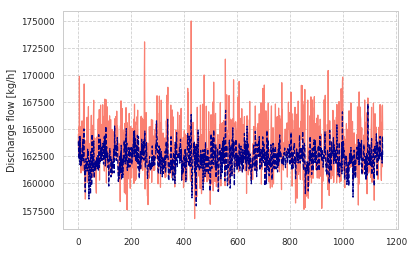

In [294]:
rf.fit(x_train, y_train[:,flow_ind])
preds = rf.predict(x_valid)

plt.figure()
plt.plot(y_valid[::1,flow_ind], color="salmon", label="true")
plt.plot(preds[::1], label="prediction", color="darkblue", linestyle="dashed")
plt.ylabel("Discharge flow [kg/h]")
plt.plot()

(3453, 6)